In [6]:
sys.path.insert(0, './common')

import sys
import wave
import a2c_model

In [7]:
env_path = 'env01/Wave'

In [8]:
env = wave.WaveEnv(env_path, worker_id=1)

WAVE environment created.


In [9]:
hidden_layer = 512
model = a2c_model.A2C(127, 2, hidden_layer, lr=1e-4)

In [10]:
save_path = './results/env01/a2c/512-nodecay-new'
model.set_model_save_path(save_path)

In [4]:
model.load_model()

Model loaded
Training history loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


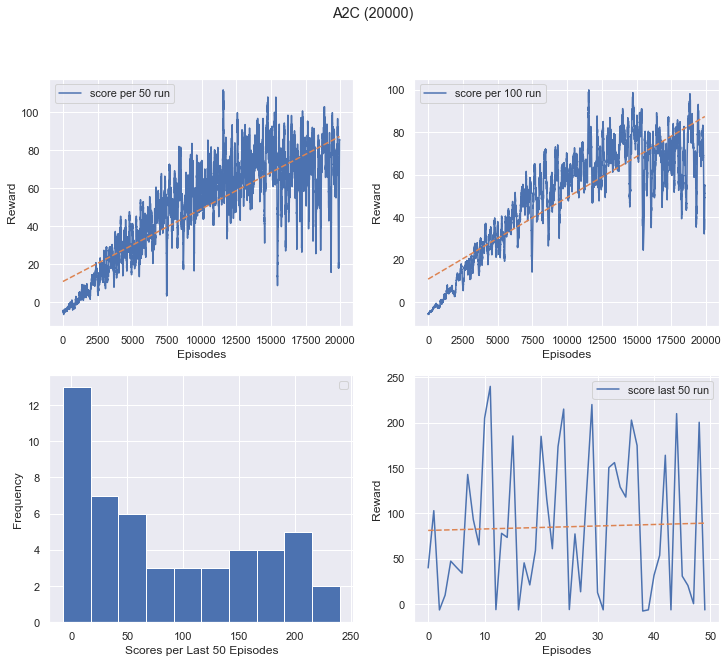

Model saved
Training history saved
saved to ./results/env01/a2c/512-nodecay-new
EPOCH: 19999, total reward: -6.21999990940094, timestep: 25


In [11]:
model.set_train_params(max_step=1000, plot_smooth=50, gamma=0.99)
model.train(env, 20000, show_plot=True, lr_decay_interval=500000)

In [7]:
model.save_model()

Training history saved


In [3]:
import saver
saver.save_wave_model(hidden_layer, f'{save_path}/actor.pth', f'{save_path}/model.onnx')

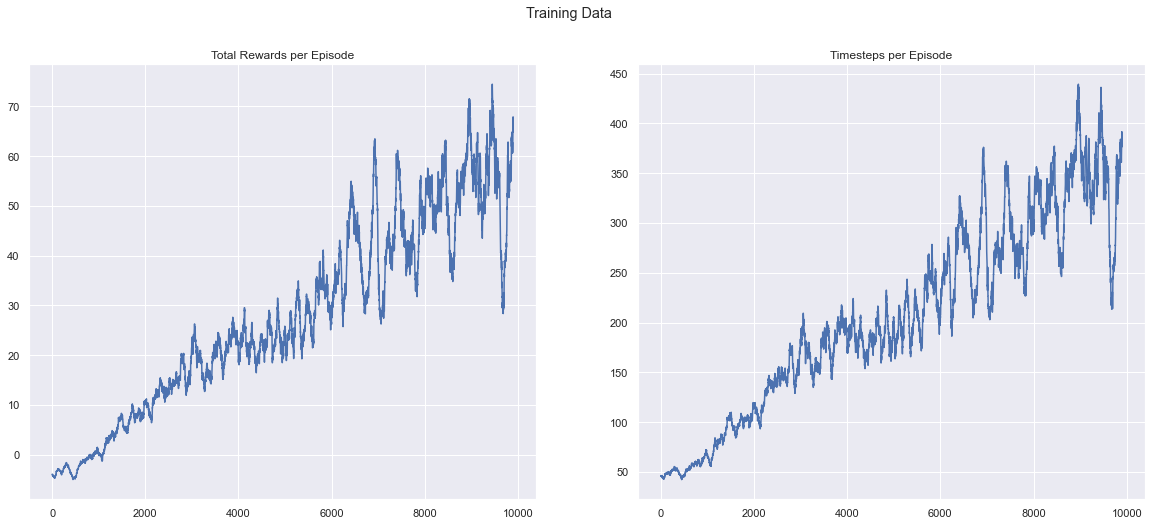

In [5]:
model.plot_train_memory(smooth=100)

In [21]:
env = wave.WaveEnv(env_path, 5, worker_id=2)
model.test(env)

WAVE environment created.


(291.5699602663517, 1469)

In [18]:
model.test_avg(lambda time_scale: wave.WaveEnv(env_path, time_scale), 10, 40)

WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.


(11.060092589631676, 124.8)

In [5]:
env.close()